[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202320_IMAGENES_Y_VISION/blob/main/Laboratorio%201/Practica/MISIS4825-M%26V2023%20-%20LAB1%20-%20Práctica%201.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)


# **Práctica No. 1**
## **Proceso de Aprendizaje Automático e Introducción a la Clasificación**

## **Objetivos**
- Familiarizarse con las librerías de Scikit-Learn y con el algoritmo de KNN
- Resolver un problema de clasificación y tomar métricas de desempeño sobre este
- Entender cómo funciona la reducción de dimensionalidad con PCA y cómo se puede aplicar a un problema de clasificación

## **Problema**
- En este caso exploraremos el dataset "Apples or tomatoes - image classification". Este dataset cuenta con 294 imágenes de entrenamiento (164 manzanillas y 130 tomates) y 97 imágenes de prueba (54 manzanillas y 43 tomates). Las imágenes presentan diversas dimensiones, siendo 100x100 la más común. El objetivo es construir un clasificador a través del algoritmo de KNN que pueda distinguir entre cada uno de estos alimentos.

Datos: https://www.kaggle.com/datasets/samuelcortinhas/apples-or-tomatoes-image-classification

Para este ejercicio, utilizaremos las siguientes librerías.

In [1]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import wasserstein_distance # Distancia de Wasserstein para comparar histogramas

from skimage import exposure # Algoritmos de ecualización de histogramas
from skimage.io import imread # Lectura de imágenes
from skimage.transform import resize # Redimensionamiento de imágenes

from sklearn.neighbors import KNeighborsClassifier # Clasificador KNN
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparámetros
from sklearn.metrics import accuracy_score # Cálculo de la precisión
from sklearn.decomposition import PCA # Análisis de componentes principales
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Matriz de confusión

#### 1. Carga y exploración de los datos

In [2]:
def load_image(folder, width, height):
    img, y=[], []
    
    for file in os.listdir(folder):
        path=os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image
            image=imread(os.path.join(path, i))
            # Resize image 
            image=resize(image, (width, height), anti_aliasing=True)
            img.append(image)
            y.append(file)
    
    return np.array(img), np.array(y)

In [3]:
# Carga de las imágenes de entrenamiento y test
x_train, y_train= load_image('data/train', 100, 100)
x_test, y_test= load_image('data/test', 100, 100)

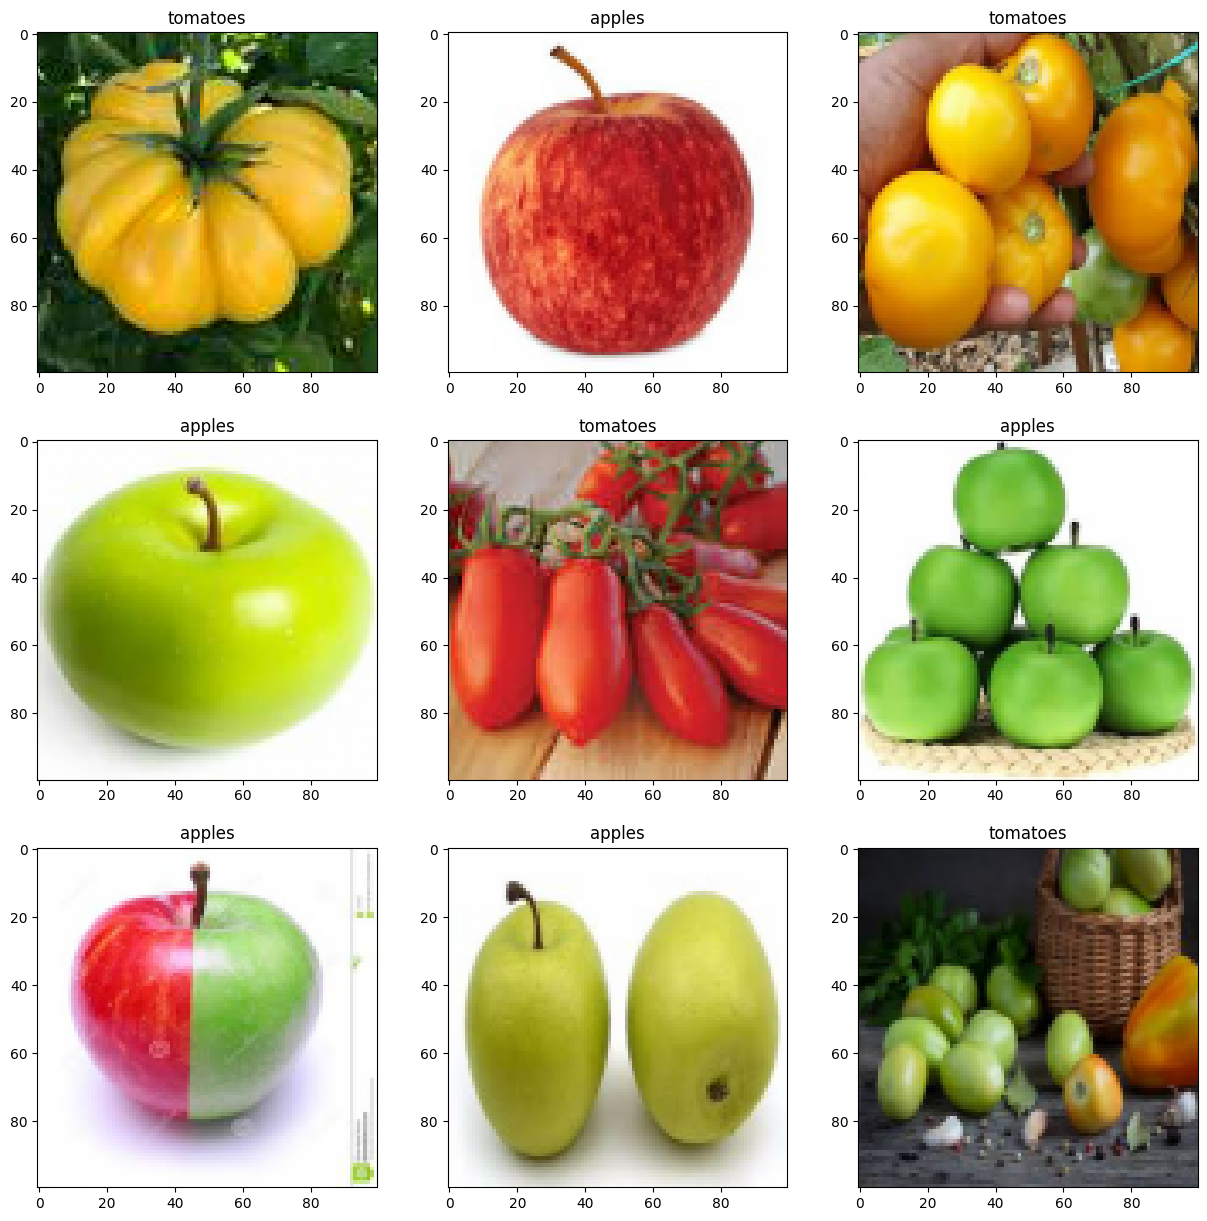

In [4]:
# Observar las imágenes
plt.figure(figsize=(15,15))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(x_train))
    plt.imshow(x_train[rdn])
    plt.title(y_train[rdn])

In [5]:
# Observar la distribución de los labels
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Distribución de los labels de entrenamiento: ", dict(zip(unique_train, counts_train)))
print("Distribución de los labels de test: ", dict(zip(unique_test, counts_test)))

Distribución de los labels de entrenamiento:  {'apples': 164, 'tomatoes': 130}
Distribución de los labels de test:  {'apples': 54, 'tomatoes': 43}


#### 2. Preparación de los Datos

##### 2.1 Elegir el mejor exposure: 
En procesamiento de imagenes exposure se refiere a la cantidad de luz que recibe una cámara para capturar una imagen. En este contexto elegir un exposure correcto nos puede ayudar a mejorar la visibilidad de caracteristicas importantes en las imágenes lo que puede potenciar los resultados de nuestro modelo.

c:\Users\USUARIO\anaconda3\lib\site-packages\skimage\_shared\utils.py:326: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


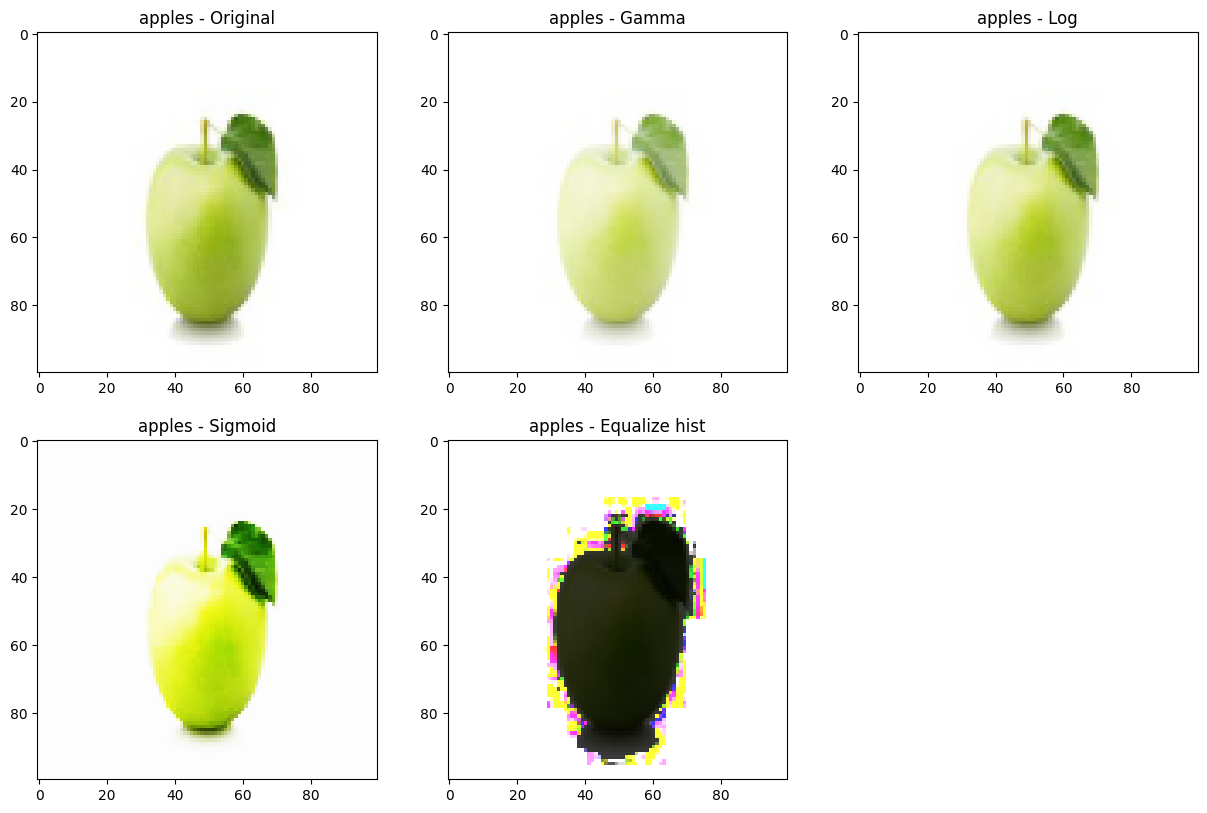

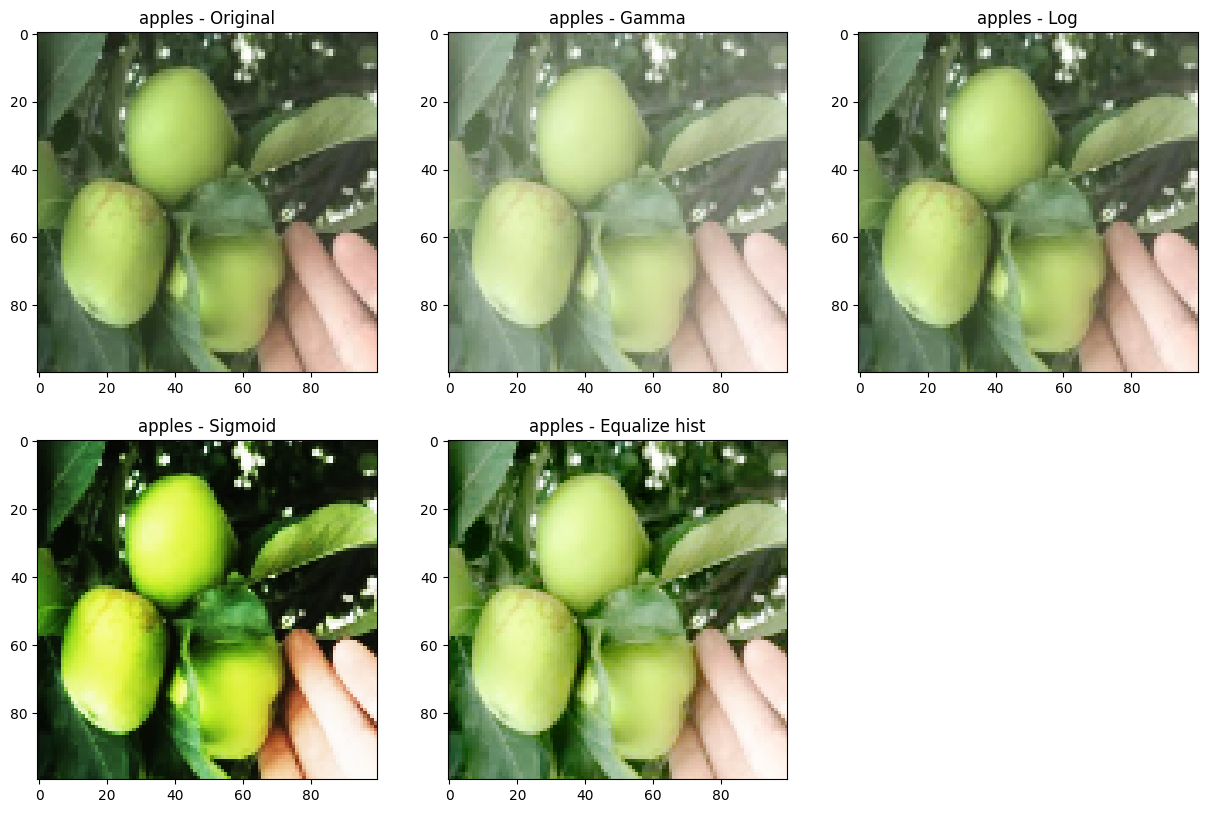

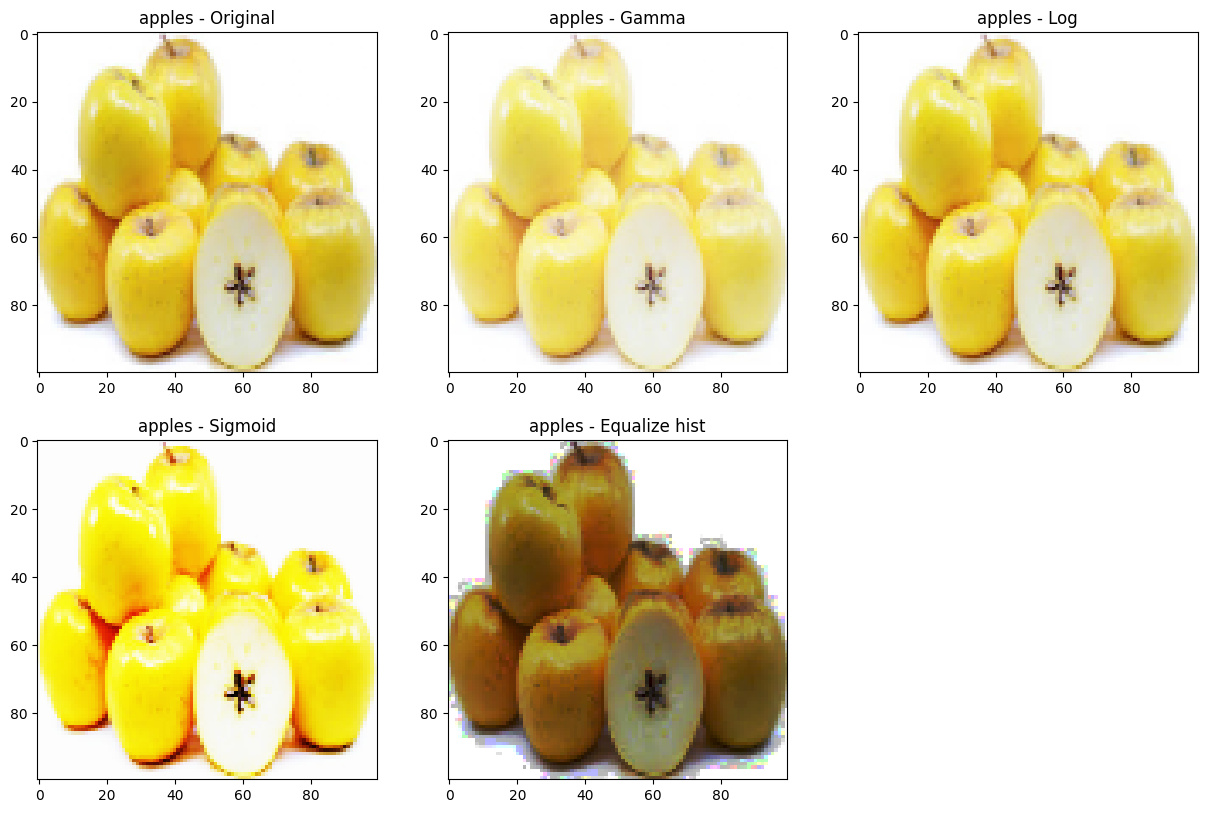

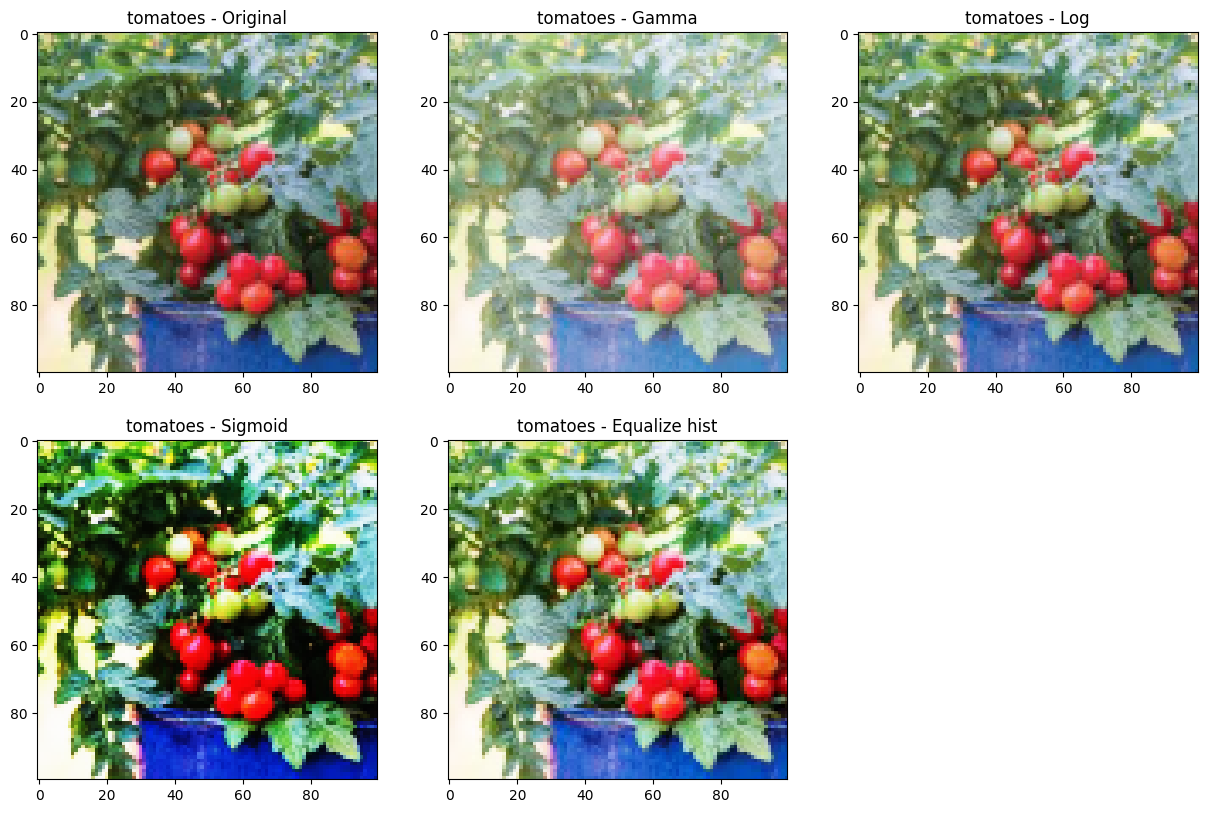

In [6]:
# Observermos si alguno de los filtros de exposure puede ayudarmnos a menorar la calida de nuestras imágenes

def plot_transformations(img, title):
    transformations = {
        'Original': img,
        'Gamma': exposure.adjust_gamma(img, 0.5),
        'Log': exposure.adjust_log(img, 1),
        'Sigmoid': exposure.adjust_sigmoid(img, 0.5, 10),
        'Equalize hist': exposure.equalize_hist(img)
    }
    
    plt.figure(figsize=(15, 15))
    for i, (key, value) in enumerate(transformations.items(), 1):
        plt.subplot(3, 3, i)
        plt.imshow(value)
        plt.title(f'{title} - {key}')

for i in range(4):
    rdn = np.random.randint(0, len(x_train))
    plot_transformations(x_train[rdn], y_train[rdn])

¿Hay una mejora significativa en las imágenes a partir de algún tipo de transformación?

En particular, utilizaremos la técnica de Exposure que ejecuta correción de sigmoide en las imágenes. Ciertas caracteristicas de la imagen llegan a resaltarse mejor con esta transformación y no se pierde información de la imagen original. 

In [7]:
x_train = exposure.adjust_sigmoid(x_train, 0.5, 10)
x_test = exposure.adjust_sigmoid(x_test, 0.5, 10)

##### 2.2 Observar outliers:

¿Hay imágenes que no se parecen a las demás? ¿Hay imagenes que no se parecen a ninguna otra? ¿Qué se puede hacer con ellas?

Observando la distribución de los histogramas de las imágenes podemos  ver si existen patrones poco comunes que le agregen ruido a nuestro modelo. Sin embargo, hay que tener especial cuidado con este método pues puede afectar a la generalización del modelo.

In [8]:
# Detectar outliers de las imágenes 
def detect_outliers(images, labels, class_label):
    class_indices = np.where(labels == class_label)[0]
    class_images = images[class_indices]
    ref_histogram = np.mean([exposure.histogram(img)[0] for img in class_images], axis=0)
    outliers = []
    for i, idx in enumerate(class_indices):
        img_histogram = exposure.histogram(class_images[i])[0]
        distance = wasserstein_distance(ref_histogram, img_histogram)
        if distance > 110:  # Definir un umbral adecuado
            outliers.append(idx)
    return outliers

# Uso
outliers_tomatoes = detect_outliers(x_train, y_train, 'tomatoes')
outliers_apples = detect_outliers(x_train, y_train, 'apples')

In [9]:
print("Encontramos {} outliers de apples".format(len(outliers_apples)))
print("Encontramos {} outliers de tomatoes".format(len(outliers_tomatoes)))

Encontramos 5 outliers de apples
Encontramos 9 outliers de tomatoes


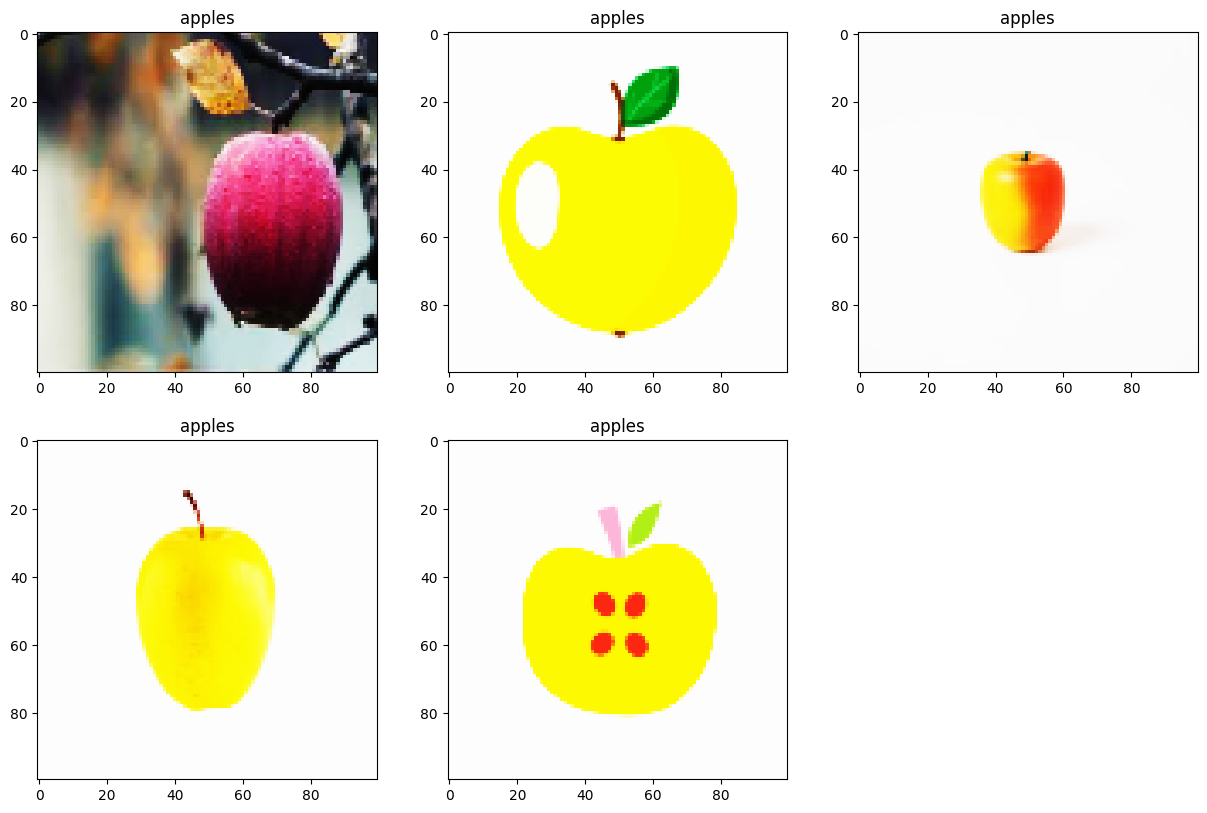

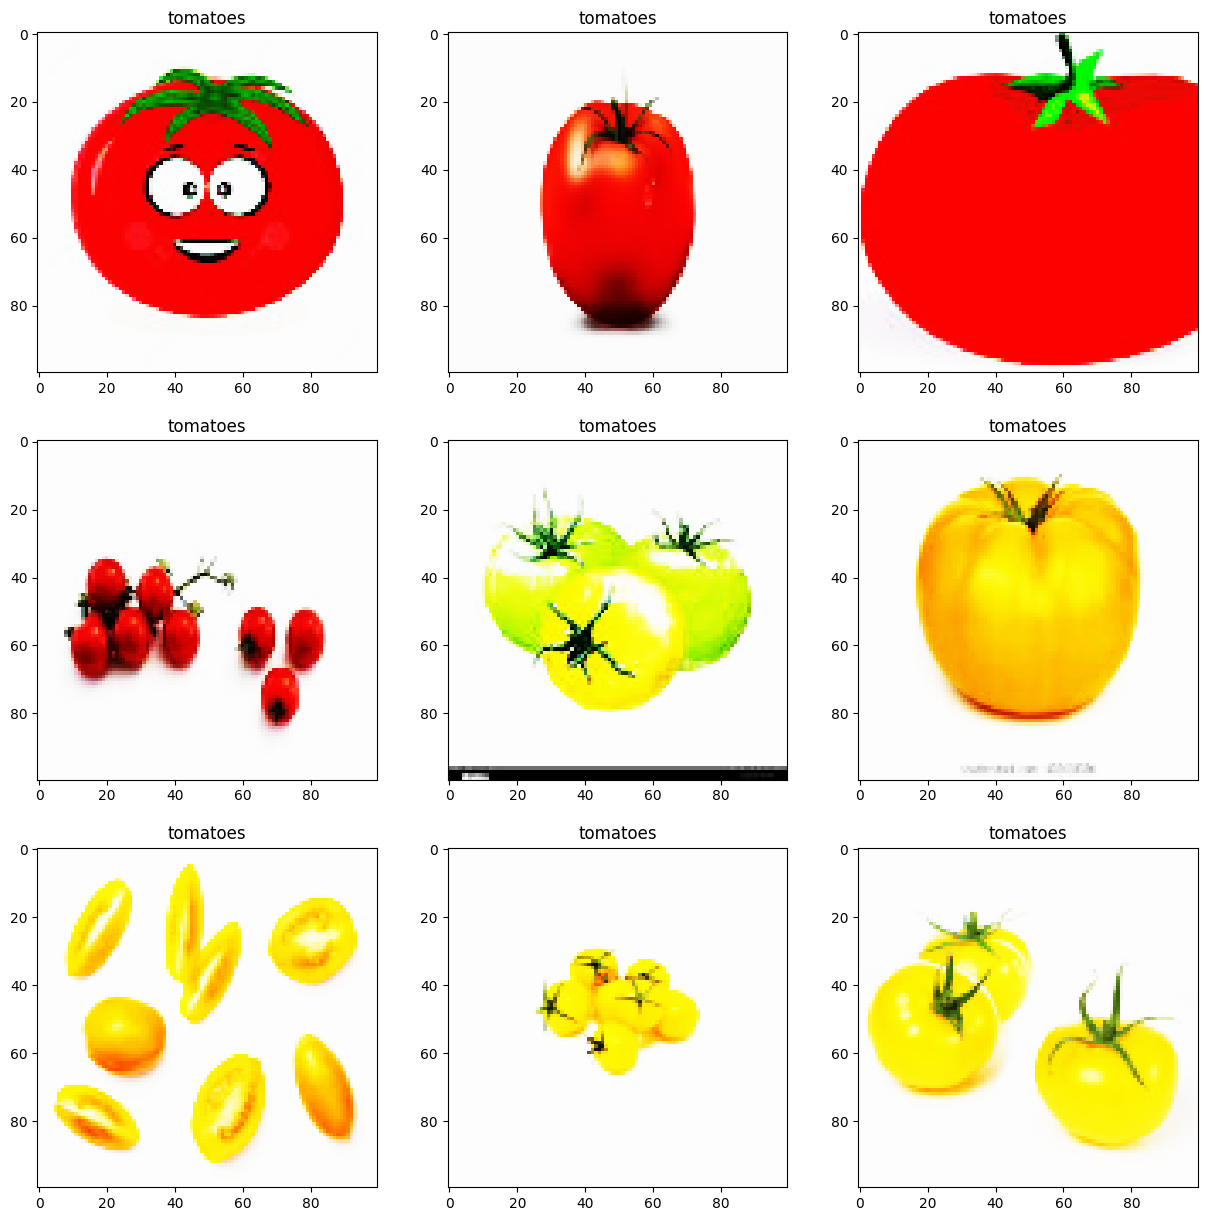

In [10]:
# Mostrar los outliers
plt.figure(figsize=(15,15))
for i in range(0, len(outliers_apples)):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[outliers_apples[i]])
    plt.title(y_train[outliers_apples[i]])

plt.figure(figsize=(15,15))
for i in range(0, len(outliers_tomatoes)):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[outliers_tomatoes[i]])
    plt.title(y_train[outliers_tomatoes[i]])

¿Vale la pena eliminar estos outliers? ¿Definitivamente no son parte de ninguna clase? ¿Se pueden eliminar sin afectar el desempeño del modelo?

Las imágenes que podemos encontrar realmente no difieren de las estructuras convencionales de las imágenes de la clase, poseen una diferencia en la disposición de histogramas, pero esto no es un factor definitivo. Las conservaremos.

##### 2.3 Normalizar los datos: 

Vamos a normalizar el valor de los pixeles de las imágenes en el rango [0,1]. Al tener una escala uniforme el modelo converge más rápido y puede aumentar el rendimiento al evitar que ciertas características dominen otras.

In [11]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

#### 3. Modelamiento

En esta sección, emplearemos el algoritmo K-Nearest Neighbors (KNN) para nuestro problema de clasificación de imágenes. KNN es un algoritmo basado en instancia que clasifica una imagen según la mayoría de clases en sus K imágenes vecinas más cercanas en el espacio de características. 

En el contexto de este problema (clasificación de manzanas y tomates) la simplicidad de KNN nos permite comparar las caracteristicas de las imágenes de una manera intuitiva.

##### K-Nearest-Neighbors

<img src="https://miro.medium.com/max/3544/1*4F-q86XFr2-EsaAcz0Zu5A.png" width="800" />

> Tomado de [Towards Data Science](https://towardsdatascience.com/k-nearest-neighbor-python-2fccc47d2a55)

##### Consideración

Debemos tener en cuenta que KNN no puede procesar imágenes directamente. Las imágenes deben ser transformadas en vectores de características. Una forma común es aplanar cada imagen en un vector unidimensional. Por ejemplo, una imagen de 100x100x3 se convierte en un vector de 30000 elementos.

In [12]:
# Aplanamiento de las imágenes 
x_train_flatten = np.array([img.flatten() for img in x_train])
x_test_flatten = np.array([img.flatten() for img in x_test])

In [13]:
# Tamaño del vector unidimensional
print(x_train_flatten.shape)

(294, 30000)


Ahora vamos a desarrollar una cuadrícula para encontrar los mejores parámetros posibles a nuestro modelo.

In [14]:
start = time.time()

param_grid = {
    'n_neighbors': np.arange(6, 15, 2),
    'weights': ['uniform'], 
    'metric': ['euclidean', 'manhattan']
}

# Crear la instancia de GridSearchCV (Grilla de búsqueda)
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="accuracy", # Nos concentraremos en la exactitud (cuántas predicciones son correctas)
                           cv=6, return_train_score=True)

# Entrenar el modelo
grid_search.fit(x_train_flatten, y_train)

end = time.time()

print("Tiempo de entrenamiento: {:.2f} segundos".format(end - start))

Tiempo de entrenamiento: 57.03 segundos


In [15]:
print("Mejor precisión: ", grid_search.best_score_)
print("Mejores parámetros: ", grid_search.best_params_)

Mejor precisión:  0.6462585034013605
Mejores parámetros:  {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}


Matriz de confusión datos de entrenamiento


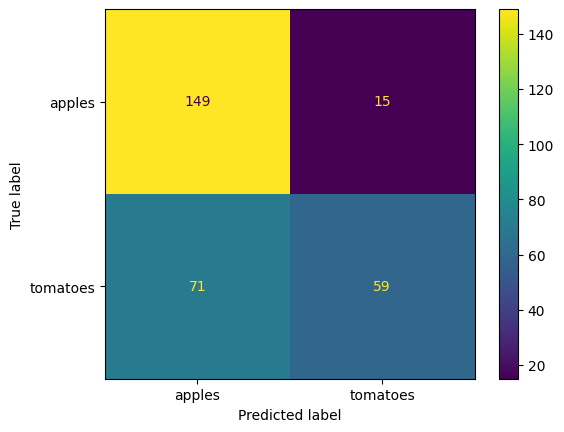

In [16]:
print("Matriz de confusión datos de entrenamiento")

# Matriz de confusión para entrenamiento
cm = confusion_matrix(y_train, grid_search.best_estimator_.predict(x_train_flatten))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_train)
disp.plot()

In [17]:
# Mejor modelo
best_model = grid_search.best_estimator_
# Predecir
y_pred = best_model.predict(x_test_flatten)
# Exactitud
print("Exactitud: ", accuracy_score(y_test, y_pred))

Exactitud:  0.6907216494845361


Matriz de confusión datos de test


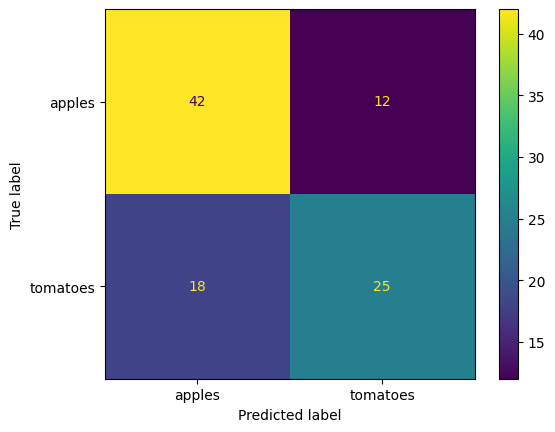

In [18]:
print("Matriz de confusión datos de test")

# Matriz de confusión para test
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_test)
disp.plot()

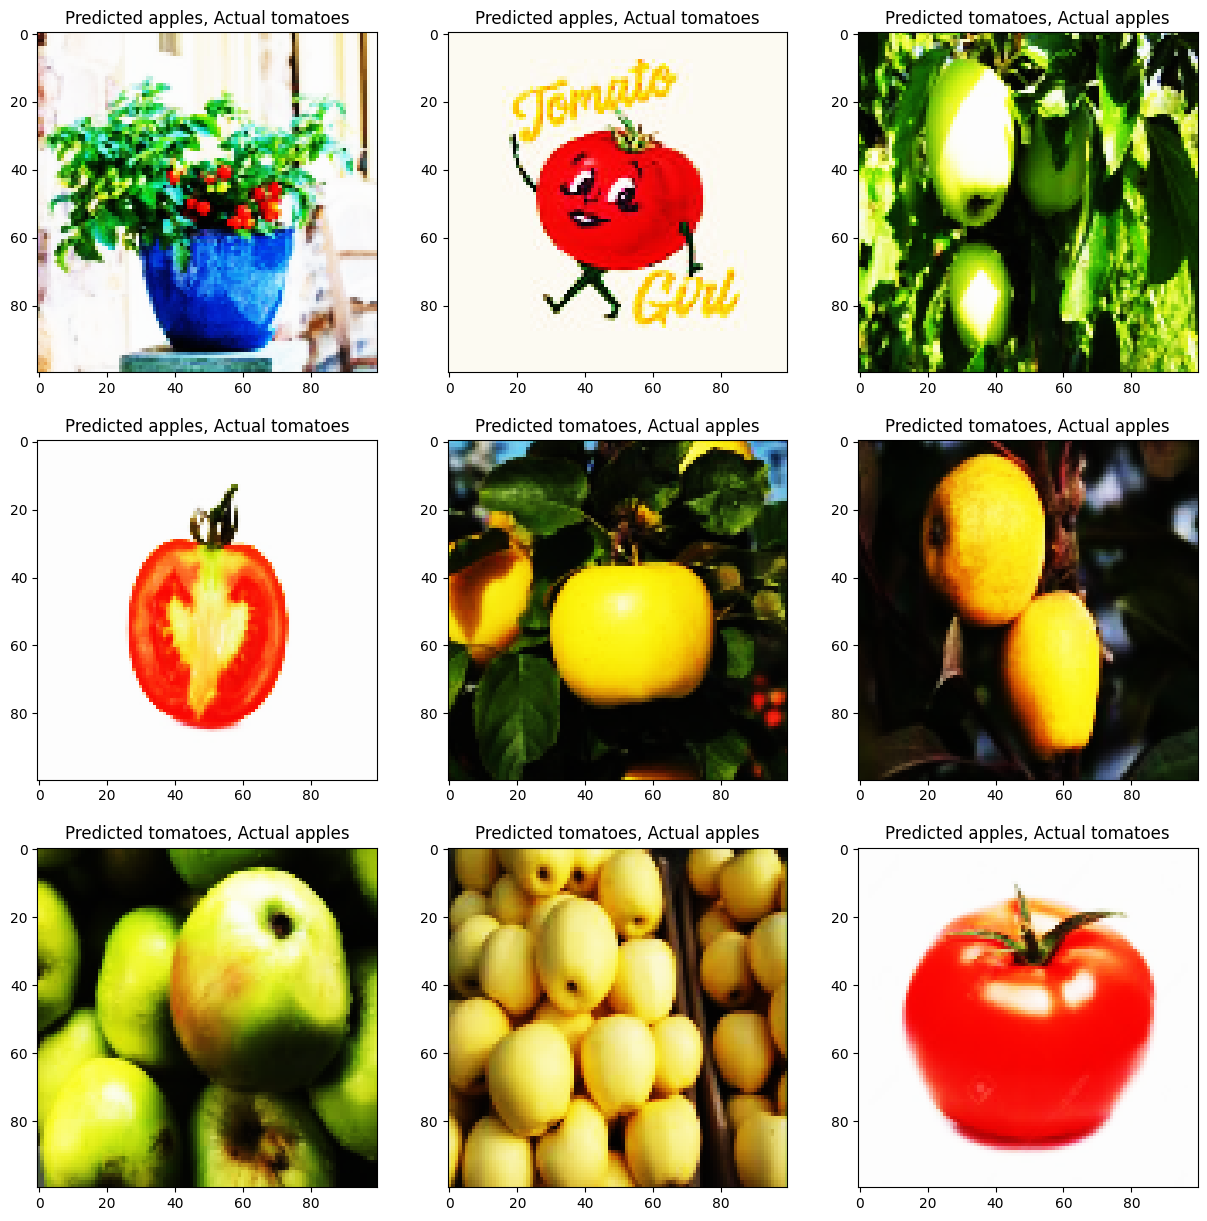

In [19]:
# Gráfico de ejemplos mal clasificados
incorrect_indices = np.nonzero(y_pred != y_test)[0]

rdn_numbers = np.random.choice(incorrect_indices, size=min(len(incorrect_indices), 9), replace=False)

plt.figure(figsize=(15,15))
for i in range(0, min(len(incorrect_indices), 9)):
    incorrect = rdn_numbers[i]
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect].reshape(100,100,3)*255.0, cmap='gray')
    plt.title(f"Predicted {y_pred[incorrect]}, Actual {y_test[incorrect]}")
plt.show()

No hay valores optimos de predicción. ¿Qué se puede hacer para mejorar el desempeño del modelo? ¿Algún otro modelo podría funcionar mejor?

#### 4. PCA

PCA es una técnica de reducción de dimensionalidad. PCA identifica las direcciones en las cuales los datos varían más y proyecta los datos en un espacio de menor dimensión, reteniendo la mayor cantidad de información posible. Al reducir la dimensionalidad, PCA permite que KNN opere en un espacio de características más manejable, mejorando potencialmente la velocidad y el rendimiento del modelo.

PCA requiere que los datos estén en un formato bidimensional donde cada fila es una muestra y cada columna es una característica. Nuestras imágenes Tienen que ser aplanadas en un vector unidimensional para poder aplicar PCA. por lo que podemos usar X_train_flat y X_test_flat.

In [20]:
# Aplicar PCA
pca = PCA(0.95) # Queremos conservar el 95% de la varianza
x_train_pca = pca.fit_transform(x_train_flatten)
x_test_pca = pca.transform(x_test_flatten)

In [21]:
start = time.time()

# Crear la instancia de GridSearchCV (Grilla de búsqueda)
param_grid = {
    'n_neighbors': np.arange(6, 15, 2),
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=6, return_train_score=True)

grid_search.fit(x_train_pca, y_train)

end = time.time()

print("Tiempo de entrenamiento: {:.2f} segundos".format(end - start))

Tiempo de entrenamiento: 0.80 segundos


In [22]:
print("Mejor precisión: ", grid_search.best_score_)
print("Mejores parámetros: ", grid_search.best_params_)

Mejor precisión:  0.6428571428571429
Mejores parámetros:  {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'uniform'}


Matriz de confusión datos de entrenamiento


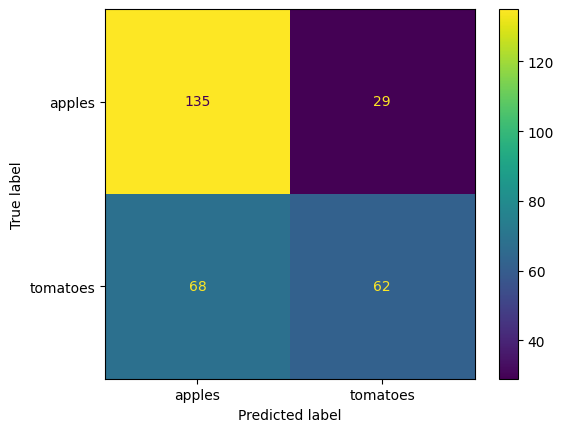

In [23]:
print("Matriz de confusión datos de entrenamiento")

# Matriz de confusión para entrenamiento
cm = confusion_matrix(y_train, grid_search.best_estimator_.predict(x_train_pca))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_train)
disp.plot()

In [24]:
# Mejor modelo
best_model = grid_search.best_estimator_
# Predecir
y_pred = best_model.predict(x_test_pca)
# Exactitud
print("Exactitud: ", accuracy_score(y_test, y_pred))

Exactitud:  0.6804123711340206


Matriz de confusión datos de test


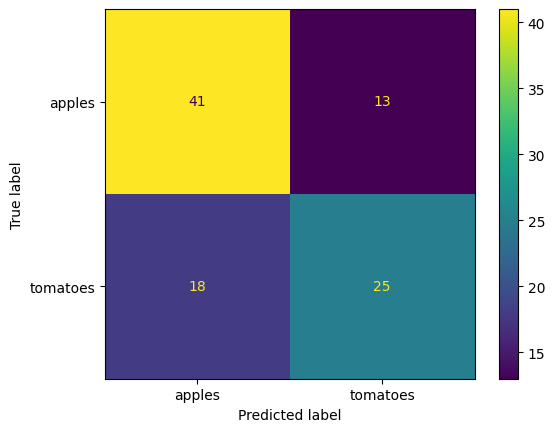

In [25]:
print("Matriz de confusión datos de test")

# Matriz de confusión para test
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_test)
disp.plot()

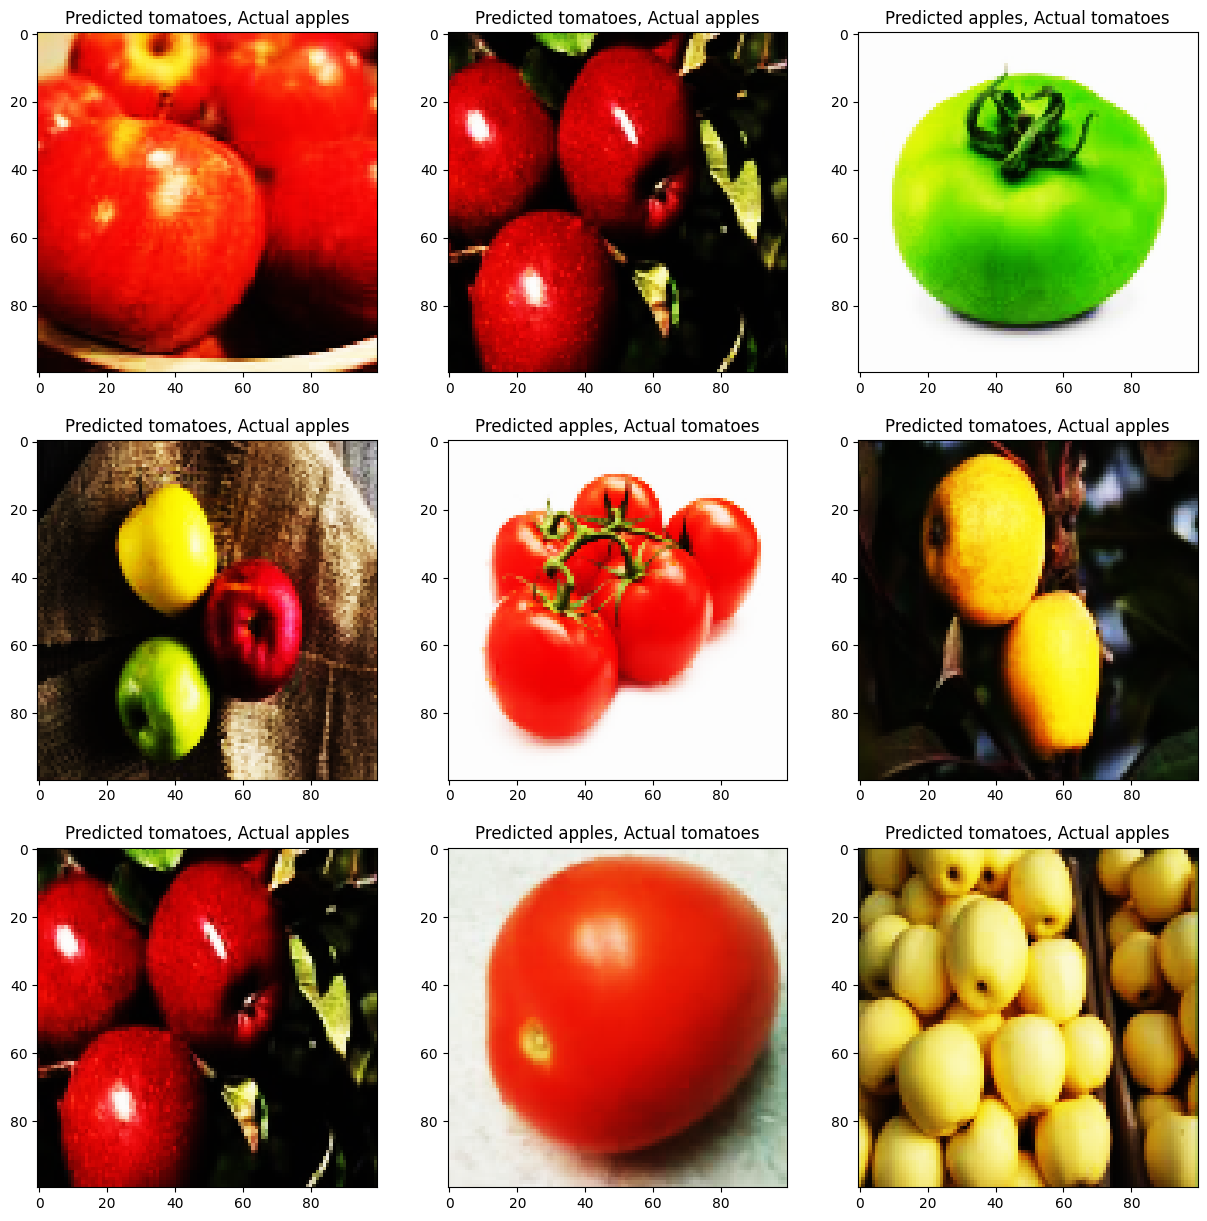

In [26]:
# Gráfico de ejemplos mal clasificados
incorrect_indices = np.nonzero(y_pred != y_test)[0]

rdn_numbers = np.random.choice(incorrect_indices, size=min(len(incorrect_indices), 9), replace=False)

plt.figure(figsize=(15,15))
for i in range(0, min(len(incorrect_indices), 9)):
    incorrect = rdn_numbers[i]
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect].reshape(100,100,3)*255.0, cmap='gray')
    plt.title(f"Predicted {y_pred[incorrect]}, Actual {y_test[incorrect]}")
plt.show()

La diferencia en las métricas de desempeño entre el modelo entrenado con datos originales y el modelo entrenado con datos transformados por PCA no es significativa. Sin embargo, se observa una notable reducción en el tiempo de entrenamiento del modelo, pasando de 57.03s a 0.80s. PCA permite conservar la esencia de la información en un espacio de menor dimensión, lo cual es beneficioso al trabajar con datos de alta dimensionalidad como las imágenes.

#### 5. Trabajo Asíncrono

1. ¿Qué pasa si se cambia el tamaño de las imágenes? ¿Se puede mejorar el desempeño del modelo?. Podemos probar aumentando o disminuyendo el ancho y alto de las mismas. Recordemos que hay imágenes que son de mayor calidad que otras.
2. Si las imágenes se leyeran en escala de grises ¿Podrían resolverse problemas de clasificación entre las clases manzana y tomate principalmente asociados al color?